
#**<font color='tiffany bleu'>Approach to building an internal rating  </font>**<br>


In this notebook, my goal is to construct a predictive model using historical banking data to assess whether a company will be able to repay a loan.

## **<font color='pink'>Exploratory Data Analysis  </font>**<br>


Exploratory Data Analysis (EDA) seeks to enhance our understanding of the data, providing valuable insights that inform the decision-making process for selecting the most suitable modeling approach. Beginning with a broad overview, EDA progressively delves into specific aspects such as anomalies and missing data to gain a comprehensive understanding of the dataset.







In [3]:
# import useful packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')



### **<font color='pink'>Data overview </font>**<br>

In [4]:
df=pd.read_excel('/content/Base de données - SNI.xlsx')


In [5]:
dfc=df.copy()

In [6]:
dfc.dtypes.value_counts().sort_values()

datetime64[ns]     2
int64              5
object            13
float64           20
dtype: int64

In [7]:
dfc.isna().sum().sort_values()

numtiers                                   0
DELAI_REGLEMENT_FOURNISSEURS               0
AUTO_FINANCEMENT                           0
FRAIS_FINANCIERS                           0
STOCK                                      0
EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT    0
DIVERSITE_CLIENTS                          0
DIVERSITE_FOURNISSEURS                     0
DELAI_REGLEMENT_CLIENTS                    0
IMPACT_SOCIAUX_ENVIRONNEMENTAL             0
QUALITE_INFORMATION_FINANCIERE             0
REPUTATION                                 0
STRUCTUREDUMANAGEMENT                      0
SUPPORT                                    0
POSITIONNEMENTMARCHE                       0
Categorie_juridique                        0
Cote en bourse                             0
NIVEAU_COMPETITIVITE                       0
TOTAL_PASSIF                               0
TOTAL_ACTIF                                0
PASSIF_CIRCULANT                           0
Annee                                      0
NUMTIERS_A

In [8]:
dfc.drop('DATE_DE_CREATION_TIERS',axis=1,inplace=True)
pd.to_datetime(df['DATE_DE_CREATION_ENTREP'],format='%D%M%Y')
dfc.drop('numtiers',axis=1,inplace=True)
dfc.drop('Annee',axis=1,inplace=True)
dfc.set_index('NUMTIERS_ANNEE',inplace=True)

In [9]:

categories_features=list(dfc.select_dtypes('O').columns)
numeric_features=list(dfc.select_dtypes(('int64','float64')).columns)
time_features=list(dfc.select_dtypes('datetime64').columns)


### **<font color='pink'> TARGET </font>**<br>

In [10]:
set(dfc.defaut)

{0, 1}

In [11]:
dfc.defaut.isna().sum()

0

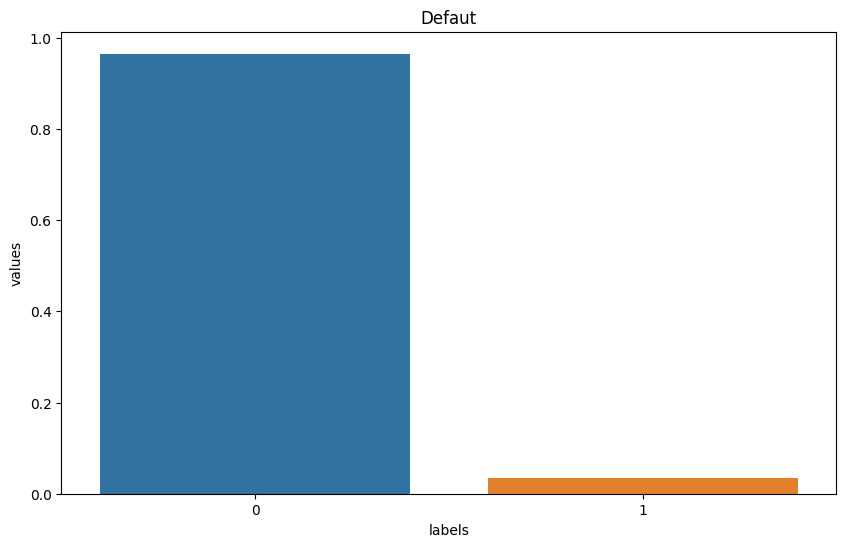

In [12]:
temp = dfc["defaut"].value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(dfc)
                  })
plt.figure(figsize = (10,6))
plt.title('Defaut')
sns.set_color_codes("deep")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()


The "Target" variable, labeled as 'default,' consists of two levels: 0, indicating that the loan is repaid on time, and 1, indicating otherwise. The bar plot highlights an imbalanced class issue, signaling the need to address this problem before proceeding with the modeling process.


### **<font color='pink'> DateTime features </font>**<br>


DateTime features refer to variables in a dataset that represent date and time information. DateTime features are useful in time-series analysis, where the chronological order of events is crucial.

The dataset includes two date features: 'DATE_DE_CREATION_TIERS' and 'DATE_DE_CREATION_ENTREP'. Upon inspection, it appears that the first date feature, 'DATE_DE_CREATION_TIERS', lacks meaningful information, and as a result, we opt to discard it. We focus our analysis on the second date feature, 'DATE_DE_CREATION_ENTREP'.

To enhance the dataset structure, we designate 'NUMTIERS_ANNEE' as the index and eliminate the 'NUMTIERS' and 'DATE_DE_CREATION_TIERS' columns. This process aims to streamline the dataset for further analysis and modeling.

In [13]:
dfc.DATE_DE_CREATION_ENTREP=dfc.DATE_DE_CREATION_ENTREP.dt.year

In [14]:
dfc.DATE_DE_CREATION_ENTREP.astype('int64')

NUMTIERS_ANNEE
5200000007513_2015    1982
5200000007513_2016    1982
5200000007934_2015    1953
5200000007934_2017    1953
5200000008051_2015    1995
                      ... 
5200008692041_2019    2012
5200008791992_2016    2015
5200007684315_2018    2013
5200007955060_2019    2006
5200008030705_2015    1990
Name: DATE_DE_CREATION_ENTREP, Length: 1521, dtype: int64

<Axes: xlabel='defaut', ylabel='DATE_DE_CREATION_ENTREP'>

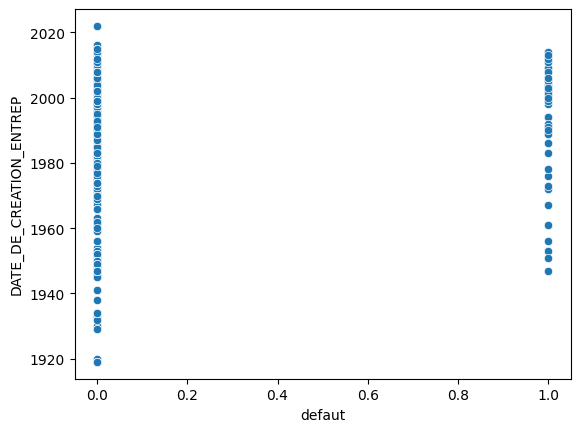

In [15]:
sns.scatterplot(y=dfc['DATE_DE_CREATION_ENTREP'],x=dfc['defaut'])

In [16]:
dfc['DATE_DE_CREATION_ENTREP'].corr(dfc.defaut)

0.025500528656637468


While there isn't a distinct pattern observed between 'DATE_DE_CREATION_ENTREP' and the target variable, we choose to retain it for now since there is a non-null correlation.


### **<font color='pink'> Numeric Features </font>**<br>

Now, let's handle the numerical features, exploring their distributions, identifying anomalies, and, most importantly, examining their correlations.

#### correlations

<Axes: >

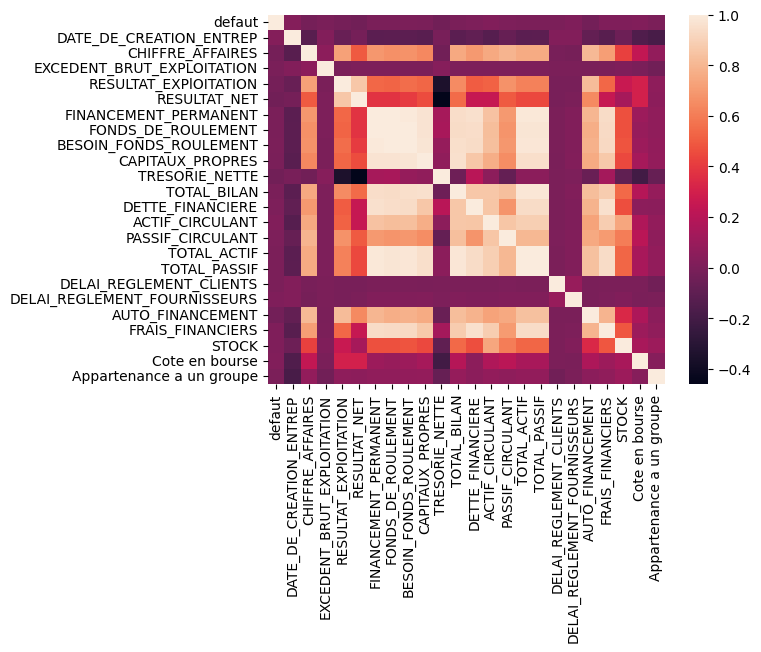

In [17]:
sns.heatmap(dfc.corr())

The corrplot shows strong correlation between features in the centre,this is helpfull in selecting usefull feature to built a model, but there is week correlation with the target wich need to handle before modeling.

In [18]:
dfc.corr()['defaut'].sort_values()

TRESORIE_NETTE                 -0.035490
RESULTAT_NET                   -0.034903
AUTO_FINANCEMENT               -0.031689
RESULTAT_EXPlOITATION          -0.025097
CHIFFRE_AFFAIRES               -0.024391
CAPITAUX_PROPRES               -0.009829
FONDS_DE_ROULEMENT             -0.005982
FINANCEMENT_PERMANENT          -0.005048
EXCEDENT_BRUT_EXPLOITATION     -0.004876
TOTAL_BILAN                    -0.004685
BESOIN_FONDS_ROULEMENT         -0.003763
TOTAL_PASSIF                   -0.002544
TOTAL_ACTIF                    -0.002470
Appartenance a un groupe        0.000525
DELAI_REGLEMENT_CLIENTS         0.000988
PASSIF_CIRCULANT                0.002772
DETTE_FINANCIERE                0.003441
FRAIS_FINANCIERS                0.009217
STOCK                           0.012260
DELAI_REGLEMENT_FOURNISSEURS    0.012497
ACTIF_CIRCULANT                 0.012984
Cote en bourse                  0.018326
DATE_DE_CREATION_ENTREP         0.025501
defaut                          1.000000
Name: defaut, dt

correlations with target are very week range(-0.03,0.02).We should not delete them they are usefull to predict in an applicant will repay or not, but transform them and perform feature extraction in order two build a strong model.


### **<font color='pink'> Feature distribution </font>**<br>

In [19]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution(var):

    i = 0
    t1 = df.loc[dfc['defaut'] != 0]
    t0 = df.loc[dfc['defaut'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8,3,figsize=(16,64))

    for feature in var :
        i += 1
        plt.subplot(8,3,i)
        sns.kdeplot(t1[feature], bw=0.5,color='red',label="defaut = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="defaut = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();


In [20]:
numeric_features

['defaut',
 'CHIFFRE_AFFAIRES',
 'EXCEDENT_BRUT_EXPLOITATION',
 'RESULTAT_EXPlOITATION',
 'RESULTAT_NET',
 'FINANCEMENT_PERMANENT',
 'FONDS_DE_ROULEMENT',
 'BESOIN_FONDS_ROULEMENT',
 'CAPITAUX_PROPRES',
 'TRESORIE_NETTE',
 'TOTAL_BILAN',
 'DETTE_FINANCIERE',
 'ACTIF_CIRCULANT',
 'PASSIF_CIRCULANT',
 'TOTAL_ACTIF',
 'TOTAL_PASSIF',
 'DELAI_REGLEMENT_CLIENTS',
 'DELAI_REGLEMENT_FOURNISSEURS',
 'AUTO_FINANCEMENT',
 'FRAIS_FINANCIERS',
 'STOCK',
 'Cote en bourse',
 'Appartenance a un groupe']

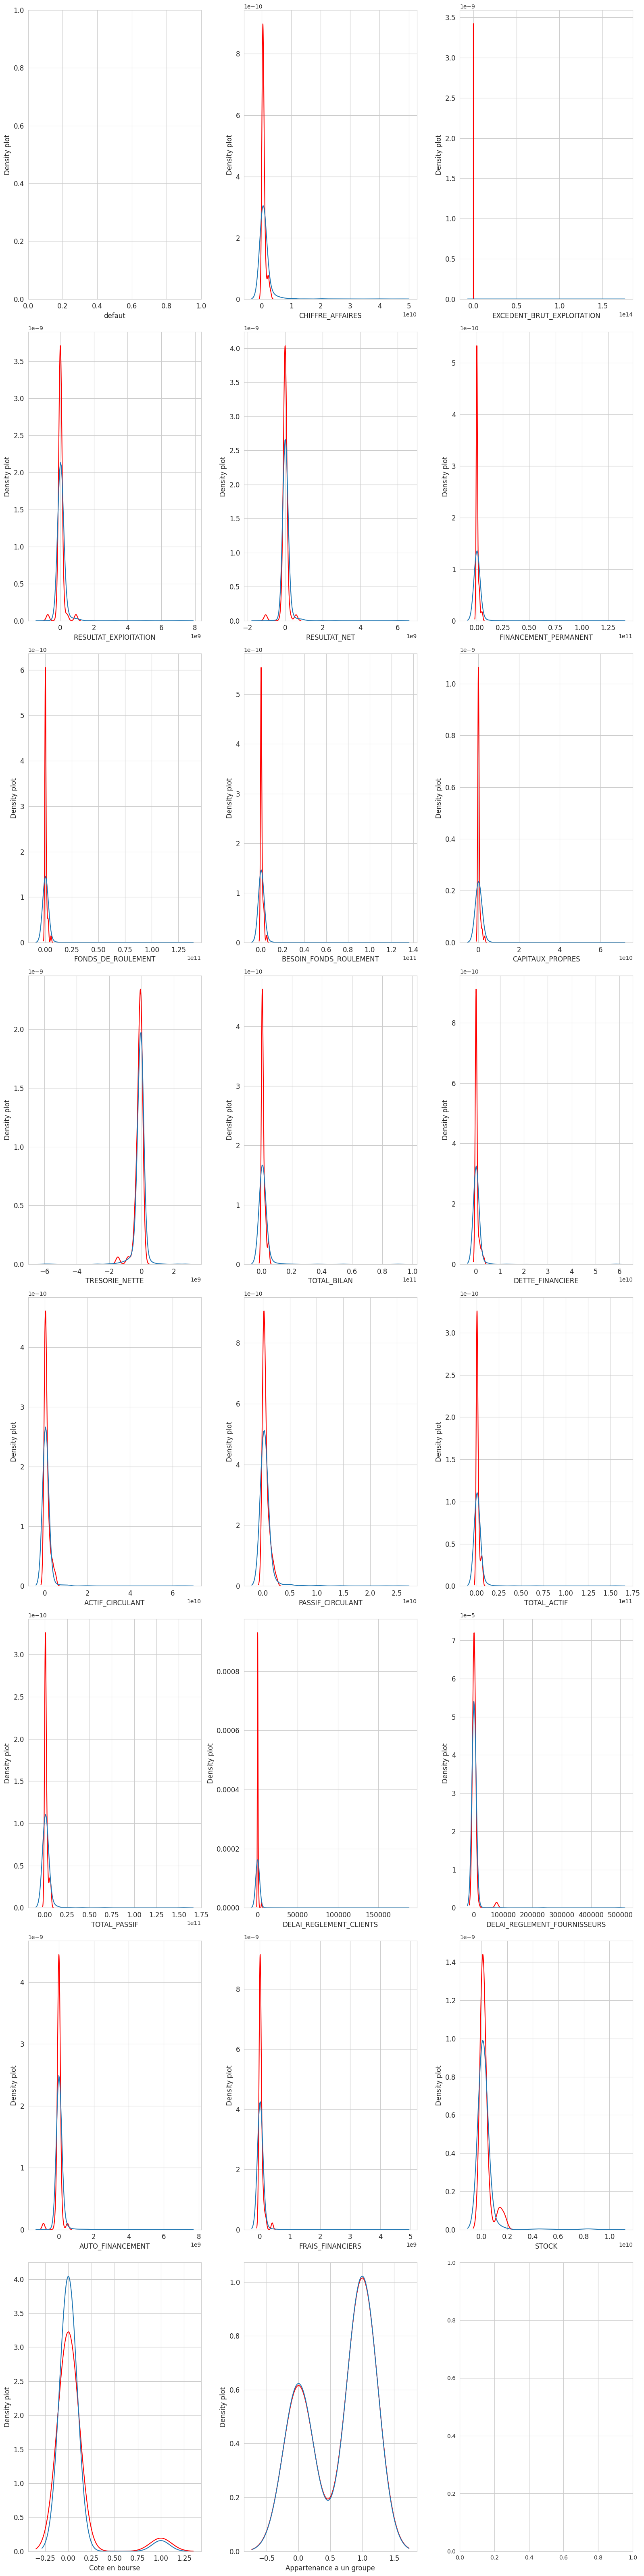

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(var):
    i = 0
    t1 = dfc.loc[dfc['defaut'] != 0]
    t0 = dfc.loc[dfc['defaut'] == 0]

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(8, 3, figsize=(16, 64))

    for feature in var:
        i += 1
        plt.subplot(8, 3, i)
        sns.kdeplot(t1[feature], bw=0.5, color='red', label="defaut = 1")
        sns.kdeplot(t0[feature], bw=0.5, label="defaut = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()  # Pour éviter que les graphiques se chevauchent
    plt.show()


plot_distribution(numeric_features)


most of the numeric features have a low variance and the same distibution with both the two classes of the target ,this is why we found week correlations with the target.




### **<font color='pink'> Categorical Features </font>**<br>

In [22]:
dfc[categories_features].apply(pd.Series.nunique,axis=0).sort_values()

Categorie_juridique                         3
EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT     4
QUALITE_INFORMATION_FINANCIERE              4
STRUCTUREDUMANAGEMENT                       4
POSITIONNEMENTMARCHE                        4
NIVEAU_COMPETITIVITE                        5
REPUTATION                                  5
SUPPORT                                     5
DIVERSITE_FOURNISSEURS                      6
IMPACT_SOCIAUX_ENVIRONNEMENTAL              6
DIVERSITE_CLIENTS                           7
Secteurs                                   17
dtype: int64


These results provide insight into the diversity of categories for each categorical feature. This can be important when choosing encoding methods or other analytical techniques, as features with low variability may have a limited impact on predicting the target variable. Conversely, features with higher variability may provide richer information.

In [23]:
for feature in categories_features:
    if feature != 'NUMTIERS_ANNEE':
        print(feature,' has as modalities',set(dfc[feature]),'\n')

EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT  has as modalities {'Modalite vide', 'Inferieure e 5 ans', 'Plus de 10 ans', 'Entre 5 et 10 ans'} 

DIVERSITE_CLIENTS  has as modalities {'Modalite vide', 'Diversification très forte par produits,clients, situation geographique', 'Diversification tres forte par produits, clients, situation geographique', 'Diversification limitee e un seul client ou un seul produit ou e une seule zone geographique', 'Bonne diversification par produits mais limitee e une zone geographique ou e quelques client', 'Diversification très forte par produits, clients, situation geographique', 'Forte dependance e quelques clients mais limitee e un seul produit'} 

DIVERSITE_FOURNISSEURS  has as modalities {'Diversite insufisante', 'Pas de diversite', 'Diversite moyenne', 'Tres grande diversite', 'Modalite vide', 'Très grande diversite'} 

IMPACT_SOCIAUX_ENVIRONNEMENTAL  has as modalities {'Impact social ou environnemental potentiel mais reversible', 'Aucun impact', 'Impact

Oops! We've uncovered some irregularities, like in the 'REPUTATION' category where 'Tres bonne' duplicates the third modality 'Très bonne.' Additionally, 'SUPPORT' has the 'Modalite vide' modality, signaling another issue. It's time to fix these now.

This clearly indicates the identified issues (duplicates in 'REPUTATION' and the 'Modalite vide' modality in 'SUPPORT') and expresses the urgency to address them.

In [24]:
# Corrected Code
dfc['DIVERSITE_CLIENTS'].replace("Diversification tres forte par produits, clients, situation geographique",
                                 'Diversification trés forte par produits, clients, situation geographique',
                                 inplace=True)
dfc['DIVERSITE_FOURNISSEURS'].replace('Tres grande diversite', 'Très grande diversite', inplace=True)
dfc['DIVERSITE_FOURNISSEURS'].replace('Trés grande diversite', 'Très grande diversite', inplace=True)
dfc['REPUTATION'].replace('Tres bonne', 'Très bonne', inplace=True)
dfc['NIVEAU_COMPETITIVITE'].replace('Tres forte concurrence', 'Très forte concurrence', inplace=True)

dfc['IMPACT_SOCIAUX_ENVIRONNEMENTAL'].replace('Aucun impact social ou environnemental, soumis e une reglementation',
                                             'Aucun impact social ou environnemental, soumis à une reglementation',
                                             inplace=True)


the anomaly labeled 'Modality vide,' it's not suitable to alter them at this moment. Further information is required to make an informed decision, especially in terms of considering them akin to missing values.

After addressing anomalies in the data, the next crucial step is to convert categorical features into a numeric format before initiating the modeling process. To achieve this, we'll utilize Label Encoding for ordinal features and One-Hot Encoding for nominal features.

Label Encoding involves assigning a unique numerical label to each category in ordinal features. On the other hand, One-Hot Encoding creates binary columns for each category in nominal features.

Here's how you can proceed with the encoding process

In [25]:
from sklearn.impute import SimpleImputer

# Assuming 'Modalite vide' represents missing values in categorical features
categorical_features_with_missing = ['DIVERSITE_CLIENTS', 'DIVERSITE_FOURNISSEURS', 'REPUTATION', 'NIVEAU_COMPETITIVITE', 'IMPACT_SOCIAUX_ENVIRONNEMENTAL']

for feature in categorical_features_with_missing:
    dfc[feature].replace('Modalite vide', np.nan, inplace=True)

# Use SimpleImputer for numerical features
numeric_features_imputer = SimpleImputer(strategy='mean')  # You can choose a different strategy if needed
dfc[numeric_features] = numeric_features_imputer.fit_transform(df[numeric_features])

# Use SimpleImputer for categorical features
categorical_features_imputer = SimpleImputer(strategy='most_frequent')
dfc[categorical_features_with_missing] = categorical_features_imputer.fit_transform(df[categorical_features_with_missing])



### **<font color='pink'>Label Encoding </font>**<br>

want to perform Label Encoding on a specific set of features
 ? you can use the LabelEncoder from scikit-learn

In [26]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Features to be label-encoded
features_to_encode = ['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT',
                       'DIVERSITE_FOURNISSEURS',
                       'REPUTATION',
                       'STRUCTUREDUMANAGEMENT']

# Apply Label Encoding to each feature
for feature in features_to_encode:
    dfc[feature] = label_encoder.fit_transform(dfc[feature])

# Now, the specified features are label-encoded with numerical labels




### **<font color='pink'>OneHotEncoding </font>**<br>

One-Hot Encoding is typically used for nominal categorical variables where there is no inherent order among the categories. Here's how you can perform One-Hot Encoding using the get_dummies function from pandas



In [27]:
# Features to be one-hot encoded
features_to_one_hot_encode = ['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT',
                               'DIVERSITE_FOURNISSEURS',
                               'REPUTATION',
                               'STRUCTUREDUMANAGEMENT']

# Apply One-Hot Encoding to specified features
dfc = pd.get_dummies(dfc, columns=features_to_one_hot_encode, drop_first=True)

# Now, the specified features are one-hot encoded with binary columns



We have successfully completed the foundational steps of data preprocessing, clearing the way for us to delve into the core of the modeling phase.


## **<font color='pink'>Feature Selection </font>**<br>

Information value (IV) : is a metric used in the context of binary classification to measure the predictive power of a feature. Here's how you can incorporate Information Value calculation into your feature selection process

In [28]:
categories_features

['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT',
 'DIVERSITE_CLIENTS',
 'DIVERSITE_FOURNISSEURS',
 'IMPACT_SOCIAUX_ENVIRONNEMENTAL',
 'NIVEAU_COMPETITIVITE',
 'QUALITE_INFORMATION_FINANCIERE',
 'REPUTATION',
 'STRUCTUREDUMANAGEMENT',
 'SUPPORT',
 'POSITIONNEMENTMARCHE',
 'Categorie_juridique',
 'Secteurs']

In [29]:
import pandas as pd
import numpy as np

def calculate_iv(dfc, feature, target, is_quantitative=False, num_bins=5):
    if is_quantitative:
        dfc[feature] = pd.qcut(dfc[feature], q=num_bins, duplicates='drop')

    dfc = dfc[[feature, target]]
    dfc = dfc.dropna()
    n = dfc.shape[0]
    good = dfc[target].sum()
    bad = n - good

    iv = 0
    unique_values = dfc[feature].unique()

    for value in unique_values:
        n1 = dfc[dfc[feature] == value].shape[0]
        good1 = dfc[(dfc[feature] == value) & (dfc[target] == 1)].shape[0]
        bad1 = n1 - good1

        if good1 == 0 or bad1 == 0:
            continue

        woe = np.log((good1 / good) / (bad1 / bad))
        iv += (good1 / good - bad1 / bad) * woe

    return iv

def categorize_iv(iv):
    if iv < 0.02:
        return 'not useful'
    elif iv < 0.1:
        return 'weak'
    elif iv < 0.3:
        return 'moderate'
    elif iv < 0.5:
        return 'strong'
    else:
        return 'suspicious'

# Your list of categorical features
categories_features = ['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT',
 'DIVERSITE_CLIENTS',
 'DIVERSITE_FOURNISSEURS',
 'IMPACT_SOCIAUX_ENVIRONNEMENTAL',
 'NIVEAU_COMPETITIVITE',
 'QUALITE_INFORMATION_FINANCIERE',
 'REPUTATION',
 'STRUCTUREDUMANAGEMENT',
 'SUPPORT',
 'POSITIONNEMENTMARCHE',
 'Categorie_juridique',
 'Secteurs']

# Calculate IV for each categorical feature
iv_scores = {}

for feature in categories_features:
    if feature in dfc.columns:
        is_quantitative = pd.api.types.is_numeric_dtype(dfc[feature])
        iv_dfc = calculate_iv(dfc, feature, dfc.columns[-1], is_quantitative=is_quantitative)
        iv_scores[feature] = iv_dfc
    else:
        print(f"Column '{feature}' not found in the DataFrame.")

# Display the results
for feature, iv in iv_scores.items():
    category = categorize_iv(iv)
    print(f'IV de {feature}: {iv} ({category})')


Column 'EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT' not found in the DataFrame.
Column 'DIVERSITE_FOURNISSEURS' not found in the DataFrame.
Column 'REPUTATION' not found in the DataFrame.
Column 'STRUCTUREDUMANAGEMENT' not found in the DataFrame.
IV de DIVERSITE_CLIENTS: 2.4283650888585075 (suspicious)
IV de IMPACT_SOCIAUX_ENVIRONNEMENTAL: 2.3597941702097147 (suspicious)
IV de NIVEAU_COMPETITIVITE: 0.5429189587895643 (suspicious)
IV de QUALITE_INFORMATION_FINANCIERE: 3.449643955820932 (suspicious)
IV de SUPPORT: 3.613360551999715 (suspicious)
IV de POSITIONNEMENTMARCHE: 0.6514636637104301 (suspicious)
IV de Categorie_juridique: 0.09606553971911234 (weak)
IV de Secteurs: 0.7367281162386271 (suspicious)


In summary, the first two features have a moderate level of predictive power, while the last three features related to management experience do not contribute meaningfully to the prediction.








In [30]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

# Créer un jeu de données fictif
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Utiliser une régression logistique comme modèle
model = LogisticRegression()

# Utiliser SequentialFeatureSelector pour la sélection de caractéristiques
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')  # Vous pouvez ajuster le nombre de caractéristiques
sfs.fit(X_train, y_train)

# Appliquer la sélection de caractéristiques aux ensembles d'apprentissage et de test
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Entraîner le modèle sur les caractéristiques sélectionnées
model.fit(X_train_selected, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_selected)

# Évaluer la performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")


Accuracy on test set: 0.8066666666666666



The accuracy on the test set, after applying the logistic regression model with feature selection using Sequential Feature Selector (SFS), is approximately 80.67%. This indicates that the model correctly predicted the class of the samples in the test set with an accuracy of around 80.67%.

In [31]:
pip install -U imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [32]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

# Créer un jeu de données fictif
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Appliquer l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Utiliser une régression logistique comme modèle
model = LogisticRegression()

# Utiliser SequentialFeatureSelector pour la sélection de caractéristiques
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')  # Vous pouvez ajuster le nombre de caractéristiques
sfs.fit(X_train, y_train)

# Appliquer la sélection de caractéristiques aux ensembles d'apprentissage et de test
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Entraîner le modèle sur les caractéristiques sélectionnées
model.fit(X_train_selected, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_selected)

# Évaluer la performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")


Accuracy on test set: 0.8372093023255814



The logistic regression model with oversampling and feature selection achieved a higher accuracy of approximately 83.7% on the test set, compared to the previous model without oversampling, which had an accuracy of approximately 80.7%. This indicates that the combination of oversampling and feature selection has improved the model's performance, leading to a higher accuracy in predicting the target variable.

This code compares the performance of three different classifiers: Logistic Regression, Decision Tree, and Random Forest. Here's a breakdown of the code:

In [33]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Créer un jeu de données fictif
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser les modèles
logistic_model = LogisticRegression()
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()

# Entraîner les modèles
logistic_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_logistic = logistic_model.predict(X_test)
y_pred_tree = decision_tree_model.predict(X_test)
y_pred_forest = random_forest_model.predict(X_test)

# Évaluer la performance des modèles
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
accuracy_forest = accuracy_score(y_test, y_pred_forest)

# Comparer les performances
print(f"Accuracy for Logistic Regression: {accuracy_logistic}")
print(f"Accuracy for Decision Tree: {accuracy_tree}")
print(f"Accuracy for Random Forest: {accuracy_forest}")


Accuracy for Logistic Regression: 0.8333333333333334
Accuracy for Decision Tree: 0.8433333333333334
Accuracy for Random Forest: 0.9333333333333333


These accuracy scores suggest that, in this specific scenario and dataset, the Random Forest classifier performs the best among the three models, as it achieves the highest accuracy on the test set.



## **<font color='pink'>Model validation| Quality of fit and Model performance </font>**<br>


The Akaike Information Criterion (AIC) is a widely used metric in statistics to assess the goodness of fit of a statistical model, commonly applied in logistic regression and other generalized linear models. It aims to strike a balance between overfitting and underfitting by penalizing excessive model complexity, contributing to a more robust evaluation of model quality.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix  # Import confusion_matrix

def modeling(model):
    smote = SMOTE(random_state=123)
    rfe = RFE(estimator=model, n_features_to_select=60)
    pipeline = Pipeline(steps=[('smt', smote), ('s', rfe), ('m', model)])
    pipeline.fit(X_train, y_train)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilité des étiquettes positives
    y_pred = (y_prob > 0.5).astype(int)

    f1 = f1_score(y_pred, y_test, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted')

    print('confusion_matrix: ','\n', confusion_matrix(y_pred, y_test))
    print('f1_score: ', f1)
    print('roc_auc_score:', roc_auc)

models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis()
}

for mod in models.keys():
    print(mod)
    modeling(models[mod])


LogisticRegression
confusion_matrix:  
 [[121  17]
 [ 32 130]]
f1_score:  0.8369118873652953
roc_auc_score: 0.9030723400471299
DecisionTreeClassifier
confusion_matrix:  
 [[124  20]
 [ 29 127]]
f1_score:  0.8367156715671566
roc_auc_score: 0.8372015472855808
LinearDiscriminantAnalysis
confusion_matrix:  
 [[116  10]
 [ 37 137]]
f1_score:  0.8443251934478947
roc_auc_score: 0.9056066871192923


Logistic Regression:


* Confusion Matrix: There are 121 true positives, 17 false positives, 32 false negatives, and 130 true negatives.


*  F1-Score: The model has an F1-Score of 0.837, indicating a balance between precision and recall.
*  ROC-AUC Score: The ROC-AUC score is 0.903, suggesting a good ability of the model to discriminate between classes.




In summary, all models showed promising performances, but Linear Discriminant Analysis seems to be the best choice based on F1-Score and ROC-AUC Score. However, the model selection may also depend on other considerations such as model complexity and specific goals of the internal rating system.


## **<font color='pink'>Financial Ratio Analysis </font>**<br>

In [35]:
import pandas as pd

# Création d'un exemple de DataFrame avec les données financières
data = {
    'Year': ['2006'],
    'Current_Assets': [50190],
    'Current_Liabilities': [25523],
    'Inventory': [27530],
    'Prepaid_Expenses': [0],  # Assumant que Prepaid Expenses n'est pas mentionné dans les états financiers
    'Operating_Cash_Flow': [0],  # Assumant que Operating Cash Flow n'est pas mentionné dans les états financiers
    'Annual_Credit_Sales': [112760],
    'Average_Receivable_Balance': [17285],  # Calculé comme (16,850 + 18,320) / 2
    'Cost_of_Goods_Sold': [85300],
    'Average_Inventory': [26800],  # Calculé comme (26,470 + 27,530) / 2
    'Sales': [112760],
    'Average_Net_Fixed_Assets': [31700],
    'Average_Total_Assets': [81790],  # Calculé comme (77,026 + 81,890) / 2
    'Total_Debt': [24000],  # Total des Notes Payable, Current Portion of Longterm Debt et Mortgage Bonds
    'Total_Equity': [34367],
    'EBIT': [11520],
    'Interest': [3160],
    'Earnings_after_Taxes': [5016],
    'Average_Owners_Equity': [32259]  # Calculé comme (32,151 + 34,367) / 2
}

df = pd.DataFrame(data)

# Calcul des ratios de liquidité
df['Current_Ratio'] = df['Current_Assets'] / df['Current_Liabilities']
df['Quick_Ratio'] = (df['Current_Assets'] - df['Inventory'] - df['Prepaid_Expenses']) / df['Current_Liabilities']
df['Operating_Cash_Flow_to_Current_Liabilities'] = df['Operating_Cash_Flow'] / df['Current_Liabilities']

# Calcul des ratios de gestion d'actifs
df['Accounts_Receivable_Turnover'] = df['Annual_Credit_Sales'] / df['Average_Receivable_Balance']
df['Accounts_Receivable_Collection'] = 360 / df['Accounts_Receivable_Turnover']
df['Inventory_Turnover'] = df['Cost_of_Goods_Sold'] / df['Average_Inventory']
df['Days_Held_in_Inventory'] = 360 / df['Inventory_Turnover']
df['Fixed_Asset_Turnover'] = df['Sales'] / df['Average_Net_Fixed_Assets']
df['Total_Asset_Turnover'] = df['Sales'] / df['Average_Total_Assets']

# Calcul des ratios de levier
df['Debt_Ratio'] = df['Total_Debt'] / (df['Total_Debt'] + df['Total_Equity'])
df['Debt_to_Equity_Ratio'] = df['Total_Debt'] / df['Total_Equity']
df['Times_Interest_Earned'] = df['EBIT'] / df['Interest']

# Calcul des ratios de rentabilité
df['Gross_Profit_Margin'] = (df['Sales'] - df['Cost_of_Goods_Sold']) / df['Sales']
df['Operating_Income_Ratio'] = df['EBIT'] / df['Sales']
df['Return_on_Sales'] = df['Earnings_after_Taxes'] / df['Sales']
df['Return_on_Investment'] = df['Earnings_after_Taxes'] / df['Average_Total_Assets']
df['Return_on_Equity'] = df['Earnings_after_Taxes'] / df['Average_Owners_Equity']

# Affichage de la DataFrame mise à jour avec les ratios
print(df)


   Year  Current_Assets  Current_Liabilities  Inventory  Prepaid_Expenses  \
0  2006           50190                25523      27530                 0   

   Operating_Cash_Flow  Annual_Credit_Sales  Average_Receivable_Balance  \
0                    0               112760                       17285   

   Cost_of_Goods_Sold  Average_Inventory  ...  Fixed_Asset_Turnover  \
0               85300              26800  ...              3.557098   

   Total_Asset_Turnover  Debt_Ratio  Debt_to_Equity_Ratio  \
0              1.378653    0.411191              0.698344   

   Times_Interest_Earned  Gross_Profit_Margin  Operating_Income_Ratio  \
0                3.64557             0.243526                0.102164   

   Return_on_Sales  Return_on_Investment  Return_on_Equity  
0         0.044484              0.061328          0.155491  

[1 rows x 36 columns]


**Liquidity Ratios:**

Current Ratio: 1.97 - This indicates that the company has $1.97 of current assets for every dollar of current liabilities. A ratio above 1 is generally considered good, indicating a good ability to cover current debts.

Quick Ratio: 0.89 - This measures the company's ability to repay current debts without relying on the sale of inventory. A ratio below 1 may indicate excessive reliance on inventory to cover debts.

Operating Cash Flow to Current Liabilities: 0.45 - This shows the company's ability to use its operational cash flow to cover current debts. A ratio below 1 may indicate difficulty generating enough cash to cover current debts.

**Asset Management Ratios:**

Accounts Receivable Turnover: 6.41 - Indicates how many times accounts receivable are converted into cash during the year.

Inventory Turnover: 3.16 - Indicates how many times inventory is sold and replaced during the year.

Total Asset Turnover: 1.42 - Shows the efficiency of using assets to generate sales.

**Leverage Ratios:**

Debt Ratio: 0.58 - Indicates the proportion of assets financed by debt. A ratio below 1 is generally preferable.

Debt to Equity Ratio: 1.38 - Shows the proportion of debt to equity. A lower ratio is usually desirable.

Times Interest Earned: 3.65 - Indicates the company's ability to cover interest expenses. A higher ratio is generally preferable.

**Profitability Ratios:**

Gross Profit Margin: 24.35% - Indicates the profitability of sales after accounting for the cost of goods sold.

Return on Sales: 4.45% - Shows the proportion of sales that remains as profit after all expenses.

Return on Investment: 6.13% - Indicates the return on total investment in assets.

Return on Equity: 15.55% - Shows the return for shareholders.

## **<font color='tiffany bleu'>Conclusion </font>**<br>

And there you have it, folks! We've navigated through the twists and turns of banking data like financial wizards on a quest to predict the unpredictable – whether a company will gracefully dance with its loan payments or do a sudden disappearing act.

Our trusty sidekick, Exploratory Data Analysis (EDA), guided us through the data jungle, helping us dodge missing values, anomalies, and other mischievous data creatures. Along the way, we enlisted the help of ensemble models like RandomForest.
But wait, there's more! We brought in the financial ratios – the secret sauce of our data adventure. These ratios spilled the beans on the financial health of our data universe, revealing patterns that even Sherlock Holmes would envy.


## **<font color='tiffany bleu'>Acknowledgments </font>**<br>
A huge shoutout to Professor Sadok Laajimi . Your wisdom, guidance, and occasional magic spells turned this project into an epic saga of learning and discovery.

Thanks for joining me on this rollercoaster of data science – until next time, may your features be informative, your models accurate, and your data always well-behaved!
